In [2]:
import re
import pandas as pd
from typing import  Literal,Optional,Any
from langchain_core.tools import tool
from langgraph.types import Command
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict, Annotated
from langchain_core.prompts.chat import ChatPromptTemplate
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field, field_validator
from langchain_core.messages import HumanMessage,AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

In [4]:
llm=ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-09-2025")

In [7]:
llm.invoke("are you more powerfull that gemini-2.5-flash")

AIMessage(content='The models I run are constantly being updated, and my capabilities are generally based on the latest versions of Google\'s large language models.\n\n**Currently, I am operating on a version of the Gemini family of models.**\n\nWhile I can\'t give you a precise, real-time comparison of every single benchmark point between my current configuration and a specific, static model like "Gemini 2.5 Flash," here is the general relationship:\n\n* **Gemini 2.5 Flash** is designed to be highly efficient, fast, and capable for its size.\n* **My underlying model** is often a more powerful variant (like **Gemini 2.5 Pro** or a similarly advanced model) or a specialized version optimized for conversational AI, which often means I have higher reasoning, context-handling, and coding capabilities than the "Flash" model.\n\n**In summary:** I am generally operating on a model that is **more powerful and capable** than Gemini 2.5 Flash, particularly in complex reasoning, large context win

In [7]:
class DateTimeModel(BaseModel):
    datetime: str = Field(..., description="A date-time string in the format DD-MM-YYYY HH:MM",pattern=r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$')

    @field_validator('datetime')
    def validate_datetime_format(cls, v):
        pattern = r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$'
        if not re.match(pattern, v):
            raise ValueError('datetime must be in the format DD-MM-YYYY HH:MM')
        return v
    
class DateModel(BaseModel):
    date: str = Field(..., description="A date string in the format DD-MM-YYYY", pattern=r'^\d{2}-\d{2}-\d{4}$')

    @field_validator('date')
    def validate_date_format(cls, v):
        pattern = r'^\d{2}-\d{2}-\d{4}$'
        if not re.match(pattern, v):
            raise ValueError('date must be in the format DD-MM-YYYY')
        return v
    
class IdentificationNumberModel(BaseModel):
    id: int = Field(..., description="An identification number(7 or 8 digit long)")
    @field_validator('id')
    def validate_id_length(cls, v):
        if not re.match(r'^\d{7,8}$', str(v)): 
            raise ValueError("The ID number should be a 7 or 8-digit number")
        return v

In [8]:
@tool
def check_availability_by_doctor(doctor_name: Literal["kevin anderson","robert martinez","susan davis","daniel miller","sarah wilson","michael green","lisa brown","jane smith","emily johnson","john doe"], desired_date: DateModel):
    """
    Check availability for a given doctor on a specific validated date.
    
    Args:
        doctor_name (DoctorName): Name of the doctor (restricted set).
        desired_date (DateModel): Validated date string in format DD-MM-YYYY.
    
    Returns:
        A message with a list if available time slots for the doctor on the selected date or a message indicating no availability.
    """
    df= pd.read_csv("doctor_availability.csv")
    available_slots = df[
        (df['doctor_name'].str.lower() == doctor_name.lower()) & 
        (df['date_slot'].str.startswith(desired_date.date)) &
        (df['is_available'] == True)
        ]['date_slot'].apply(lambda dt: dt.split(' ')[-1]).tolist()
    
    if len(available_slots) == 0:
        return f"No available slots for Dr. {doctor_name} on {desired_date.date} in the entire day."
    else:
        slots_str = ', '.join(available_slots)
        return f"Available slots for Dr. {doctor_name} on {desired_date.date} are: {slots_str}."

In [7]:
date_instance = DateModel(date="02-09-2024")
print(date_instance)

date='02-09-2024'


In [8]:
print(check_availability_by_doctor.invoke({"desired_date": date_instance, "doctor_name": "kevin anderson"}))

Available slots for Dr. kevin anderson on 02-09-2024 are: 08:30, 09:00, 10:00, 10:30, 11:00, 11:30, 12:30, 13:00, 13:30, 14:30, 15:00, 15:30, 16:00, 16:30.


In [9]:
def convert_to_am_pm(time):
    """Convert time from 24-hour format to 12-hour AM/PM format."""
    hour, minute = map(int, time.split(':'))
    period = 'AM' if hour < 12 else 'PM'
    hour = hour % 12
    hour = 12 if hour == 0 else hour
    return f"{hour}:{minute:02d} {period}"

@tool
def check_availability_by_specialization(specialization: Literal["general_dentist", "cosmetic_dentist", "prosthodontist", "pediatric_dentist","emergency_dentist","oral_surgeon","orthodontist"], desired_date: DateModel):
    """
    Check availability for doctors of a given specialization on a specific validated date.
    
    Args:
        specialization (Specialization): Specialization of the doctor (restricted set).
        desired_date (DateModel): Validated date string in format DD-MM-YYYY.
    
    Returns:
        A message with a list if available time slots for doctors of the given specialization on the selected date or a message indicating no availability.
    """
    df= pd.read_csv("doctor_availability.csv")
    available_slots = df[
        (df['specialization'].str.lower() == specialization.lower()) & 
        (df['date_slot'].str.startswith(desired_date.date)) &
        (df['is_available'] == True)
        ][['doctor_name','date_slot']]
    
    if available_slots.empty:
        return f"No available slots for {specialization.replace('_', ' ')} on {desired_date.date} in the entire day."
    else:
        result_lines = []
        for _, row in available_slots.iterrows():
            time_slot = convert_to_am_pm(row['date_slot'].split(' ')[-1])
            result_lines.append(f"Dr. {row['doctor_name']} at {time_slot}")
        result_str = '\n'.join(result_lines)
        return f"Available slots for {specialization.replace('_', ' ')} on {desired_date.date} are:\n{result_str}."

In [26]:
print(check_availability_by_specialization.invoke({"desired_date": date_instance, "specialization": "orthodontist"}))

Available slots for orthodontist on 02-09-2024 are:
Dr. kevin anderson at 8:30 AM
Dr. kevin anderson at 9:00 AM
Dr. kevin anderson at 10:00 AM
Dr. kevin anderson at 10:30 AM
Dr. kevin anderson at 11:00 AM
Dr. kevin anderson at 11:30 AM
Dr. kevin anderson at 12:30 PM
Dr. kevin anderson at 1:00 PM
Dr. kevin anderson at 1:30 PM
Dr. kevin anderson at 2:30 PM
Dr. kevin anderson at 3:00 PM
Dr. kevin anderson at 3:30 PM
Dr. kevin anderson at 4:00 PM
Dr. kevin anderson at 4:30 PM.


In [10]:
@tool
def book_appointment(doctor_name: Literal["kevin anderson","robert martinez","susan davis","daniel miller","sarah wilson","michael green","lisa brown","jane smith","emily johnson","john doe"], appointment_datetime: DateTimeModel, patient_id: IdentificationNumberModel):
    """
    Book an appointment with a specific doctor at a given validated date and time for a patient with a validated ID.
    
    Args:
        doctor_name (DoctorName): Name of the doctor (restricted set).
        appointment_datetime (DateTimeModel): Validated date-time string in format DD-MM-YYYY HH:MM.
        patient_id (IdentificationNumberModel): Validated patient ID (7 or 8 digit long).
    
    Returns:
        A confirmation message if the appointment is successfully booked or a message indicating unavailability.
    """
    df= pd.read_csv("doctor_availability.csv")
    slot_str = f"{appointment_datetime.datetime}"
    is_available = not df[
        (df['doctor_name'].str.lower() == doctor_name.lower()) & 
        (df['date_slot'] == slot_str) &
        (df['is_available'] == True)
        ].empty
    
    if is_available:
        df.loc[
            (df['doctor_name'].str.lower() == doctor_name.lower()) & 
            (df['date_slot'] == slot_str), ['is_available','patient_to_attend']
        ] = [False,patient_id.id]

        df.to_csv("doctor_availability.csv", index=False)
        return f"Appointment successfully booked with Dr. {doctor_name} on {appointment_datetime.datetime} for patient ID {patient_id.id}."
    else:
        return f"Sorry, Dr. {doctor_name} is not available on {appointment_datetime.datetime}. Please choose a different time."

In [28]:
Date = DateTimeModel(datetime="14-08-2024 08:30")
Date

DateTimeModel(datetime='14-08-2024 08:30')

In [29]:
IDNumber = IdentificationNumberModel(id=1000097)
IDNumber 

IdentificationNumberModel(id=1000097)

In [31]:
print(book_appointment.invoke({"appointment_datetime":Date,"patient_id":IDNumber,"doctor_name":"john doe"}))

Sorry, Dr. john doe is not available on 14-08-2024 08:30. Please choose a different time.


In [11]:
@tool
def reschedule_appointment(doctor_name: Literal["kevin anderson","robert martinez","susan davis","daniel miller","sarah wilson","michael green","lisa brown","jane smith","emily johnson","john doe"], old_appointment_datetime: DateTimeModel, new_appointment_datetime: DateTimeModel, patient_id: IdentificationNumberModel):
    """
    Reschedule an existing appointment with a specific doctor from an old date and time to a new date and time for a patient with a validated ID.
    
    Args:
        doctor_name (DoctorName): Name of the doctor (restricted set).
        old_appointment_datetime (DateTimeModel): Validated old date-time string in format DD-MM-YYYY HH:MM.
        new_appointment_datetime (DateTimeModel): Validated new date-time string in format DD-MM-YYYY HH:MM.
        patient_id (IdentificationNumberModel): Validated patient ID (7 or 8 digit long).
    
    Returns:
        A confirmation message if the appointment is successfully rescheduled or a message indicating failure due to unavailability or no existing appointment.
    """
    df= pd.read_csv("doctor_availability.csv")
    old_slot_str = f"{old_appointment_datetime.datetime}"
    new_slot_str = f"{new_appointment_datetime.datetime}"
    
    appointment_exists = not df[
        (df['doctor_name'].str.lower() == doctor_name.lower()) & 
        (df['date_slot'] == old_slot_str) &
        (df['patient_to_attend'] == patient_id.id) &
        (df['is_available'] == False)
        ].empty
    
    new_slot_available = not df[
        (df['doctor_name'].str.lower() == doctor_name.lower()) & 
        (df['date_slot'] == new_slot_str) &
        (df['is_available'] == True)
        ].empty
    
    if appointment_exists and new_slot_available:
        # Cancel old appointment
        df.loc[
            (df['doctor_name'].str.lower() == doctor_name.lower()) & 
            (df['date_slot'] == old_slot_str) &
            (df['patient_to_attend'] == patient_id.id), ['is_available','patient_to_attend']
        ] = [True, None]
        
        # Book new appointment
        df.loc[
            (df['doctor_name'].str.lower() == doctor_name.lower()) & 
            (df['date_slot'] == new_slot_str), ['is_available','patient_to_attend']
        ] = [False, patient_id.id]

        df.to_csv("doctor_availability.csv", index=False)
        return f"Appointment with Dr. {doctor_name} has been successfully rescheduled from {old_appointment_datetime.datetime} to {new_appointment_datetime.datetime} for patient ID {patient_id.id}."
    elif not appointment_exists:
        return f"No existing appointment found with Dr. {doctor_name} on {old_appointment_datetime.datetime} for patient ID {patient_id.id}."
    else:
        return f"Sorry, Dr. {doctor_name} is not available on {new_appointment_datetime.datetime}. Please choose a different time."

In [34]:
Old_Date_Time = DateTimeModel(datetime="14-08-2024 08:30")
Old_Date_Time

DateTimeModel(datetime='14-08-2024 08:30')

In [35]:
New_Date_Time = DateTimeModel(datetime="14-08-2024 09:00")
New_Date_Time

DateTimeModel(datetime='14-08-2024 09:00')

In [36]:
IDNumber = IdentificationNumberModel(id=1000097)
IDNumber 

IdentificationNumberModel(id=1000097)

In [37]:
print(reschedule_appointment.invoke({"old_appointment_datetime": Old_Date_Time,"new_appointment_datetime": New_Date_Time,"patient_id":IDNumber, "doctor_name": "john doe"}))

Appointment with Dr. john doe has been successfully rescheduled from 14-08-2024 08:30 to 14-08-2024 09:00 for patient ID 1000097.


In [12]:
@tool
def cancel_appointment(doctor_name: Literal["kevin anderson","robert martinez","susan davis","daniel miller","sarah wilson","michael green","lisa brown","jane smith","emily johnson","john doe"], appointment_datetime: DateTimeModel, patient_id: IdentificationNumberModel):
    """
    Cancel an existing appointment with a specific doctor at a given validated date and time for a patient with a validated ID.
    
    Args:
        doctor_name (DoctorName): Name of the doctor (restricted set).
        appointment_datetime (DateTimeModel): Validated date-time string in format DD-MM-YYYY HH:MM.
        patient_id (IdentificationNumberModel): Validated patient ID (7 or 8 digit long).
    
    Returns:
        A confirmation message if the appointment is successfully canceled or a message indicating no such appointment exists.
    """
    df= pd.read_csv("doctor_availability.csv")
    slot_str = f"{appointment_datetime.datetime}"
    appointment_exists = not df[
        (df['doctor_name'].str.lower() == doctor_name.lower()) & 
        (df['date_slot'] == slot_str) &
        (df['patient_to_attend'] == patient_id.id) &
        (df['is_available'] == False)
        ].empty
    
    if appointment_exists:
        df.loc[
            (df['doctor_name'].str.lower() == doctor_name.lower()) & 
            (df['date_slot'] == slot_str) &
            (df['patient_to_attend'] == patient_id.id), ['is_available','patient_to_attend']
        ] = [True, None]

        df.to_csv("doctor_availability.csv", index=False)
        return f"Appointment with Dr. {doctor_name} on {appointment_datetime.datetime} for patient ID {patient_id.id} has been successfully canceled."
    else:
        return f"No existing appointment found with Dr. {doctor_name} on {appointment_datetime.datetime} for patient ID {patient_id.id}."

In [40]:
Date = DateTimeModel(datetime="14-08-2024 09:00")
Date

DateTimeModel(datetime='14-08-2024 09:00')

In [41]:
print(cancel_appointment.invoke({"appointment_datetime": Date,"patient_id":IDNumber,"doctor_name":"john doe"}))

Appointment with Dr. john doe on 14-08-2024 09:00 for patient ID 1000097 has been successfully canceled.


In [13]:
class Router(BaseModel):
    next: Literal["information_node", "booking_node", "FINISH"] = Field(...,
        description=(
            "Determines which specialized worker to activate next in the workflow sequence: "
            "'information_node' when the user requests FAQs or doctor availability, "
            "'booking_node' when the user wants to book, reschedule, or cancel an appointment, "
            "'FINISH' when the user's query is fully resolved and no further action is required."
        )
    )
    reasoning: str = Field(...,
        description=(
            "Detailed justification for the routing decision, explaining the rationale but in short "
            "behind selecting the particular worker and how this advances the task toward resolution."
        )
    )

In [14]:
class AgentState(TypedDict):
    messages: Annotated[list[Any], add_messages]
    id_number: int
    query: str
    rephrased_query: str
    current_reasoning: str

In [15]:
members_dict = {
    'information_node': 'Specialized agent to provide information related to doctor availability or FAQs about the hospital.',
    'booking_node': 'Specialized agent to book, cancel, or reschedule appointments.',
    'FINISH': 'Use FINISH when the user\'s query has been fully resolved or no further action is required'
}

In [16]:
options = list(members_dict.keys())

In [17]:
options

['information_node', 'booking_node', 'FINISH']

In [18]:
worker_info = '\n\n'.join(
    [f'WORKER: {member} \nDESCRIPTION: {description}' for member, description in members_dict.items()]
) 
print(worker_info)

WORKER: information_node 
DESCRIPTION: Specialized agent to provide information related to doctor availability or FAQs about the hospital.

WORKER: booking_node 
DESCRIPTION: Specialized agent to book, cancel, or reschedule appointments.

WORKER: FINISH 
DESCRIPTION: Use FINISH when the user's query has been fully resolved or no further action is required


In [19]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the following workers. "
    "### SPECIALIZED ASSISTANT:\n"
    f"{worker_info}\n\n"
    "Your primary role is to help the user make an appointment with a doctor and provide updates on FAQs and doctor availability. "
    "If the user requests information about doctors or hospital FAQs, delegate to the information_node. "
    "If the user wants to book, cancel, or reschedule an appointment, delegate to the booking_node. "
    "If the user’s request involves multiple steps (e.g., check availability and then book), first delegate to the confirmation_node to get explicit user confirmation before proceeding. "
    "Each worker will perform its task and return results. "
    "When all tasks are complete and the user query is resolved, respond with FINISH.\n\n"

    "**IMPORTANT RULES:**\n"
    "1. If the user's query is fully answered and no further action is required, respond with FINISH.\n"
    "2. If the conversation becomes repetitive, circular, or unproductive, respond with FINISH.\n"
    "3. If the conversation exceeds 10 steps, respond with FINISH to prevent infinite loops.\n"
    "4. Always consider the last worker response and previous context to determine if the user’s intent has been satisfied. "
    "If it has, respond with FINISH.\n"
)

In [20]:
print(system_prompt)

You are a supervisor tasked with managing a conversation between the following workers. ### SPECIALIZED ASSISTANT:
WORKER: information_node 
DESCRIPTION: Specialized agent to provide information related to doctor availability or FAQs about the hospital.

WORKER: booking_node 
DESCRIPTION: Specialized agent to book, cancel, or reschedule appointments.

WORKER: FINISH 
DESCRIPTION: Use FINISH when the user's query has been fully resolved or no further action is required

Your primary role is to help the user make an appointment with a doctor and provide updates on FAQs and doctor availability. If the user requests information about doctors or hospital FAQs, delegate to the information_node. If the user wants to book, cancel, or reschedule an appointment, delegate to the booking_node. If the user’s request involves multiple steps (e.g., check availability and then book), first delegate to the confirmation_node to get explicit user confirmation before proceeding. Each worker will perform i

In [21]:
class query_classifierRoute(BaseModel):
    next_node: Literal["supervisor_node", "end"] = Field(
        ..., description="Determines the next node in the agent flow"
    )
    answer: Optional[str] = Field(
        None,
        description="Only filled if next_node is 'end'. Contains the assistant's reply to the user"
    )
    rephrased_query: Optional[str] = Field(
        None,
        description="Only filled if next_node is 'supervisor_node'. Contains the rewritten standalone query. Include patient_id if required"
    )

In [22]:
def query_classifier(state: AgentState) -> Command[Literal['supervisor','__end__']]:
    message_history = state['messages']
    user_query = state['query']
    patient_id = state['id_number']

    query_classifier_prompt=(
        "You are an intelligent routing agent designed to direct user queries to the most appropriate tool."
        """
        You will receive:
            - patient_id
            - conversation history
            - the latest user query"""
        "Your job is to classify and handle patient queries"
        """
        Routing Rules:
            1. If the query is related to doctor tasks, choose supervisor_node:
            Checking doctor availability (by doctor name or specialization).
            Booking an appointment.
            Canceling an appointment.
            Rescheduling an appointment.
            When routing to supervisor_node:
            Always rephrase the query into a clear standalone question.
            If the task requires a patient_id (book, cancel, reschedule), explicitly include the patient_id in the rewritten query.
            If the task does not require a patient_id, do not include it.

            2. If the query is NOT related to doctor tasks, choose end:
            For greetings or small talk (e.g., “Hi”, “How are you?”).
            For identity questions (e.g., “Who are you?” → respond: “I am DocuBot – your Doctor Appointment Assistant.”).
            For anything beyond your knowledge → politely apologize.
            When routing to end:
            You must always provide an answer.
        """
        """
        Output Format
            {
                "next_node": "end" | "supervisor_node",
                "answer": "Only required if next_node is 'end'",
                "rephrased_query": "Only required if next_node is 'supervisor_node'"
            }
            Example 1 – Greeting:
            Patient: “Hi”

            {
            "next_node": "end",
            "answer": "Hello! How can I help you with your doctor appointments today?"
            }
            Example 2 – Book Appointment (with patient_id):
            Patient: “Book me an appointment with a cardiologist” (patient_id = 12345)

            {
            "next_node": "supervisor_node",
            "rephrased_query": "Book an appointment with a cardiologist for patient_id 12345"
            }
            Example 3 – Doctor Availability:
            Patient: “Is Dr. Sharma available tomorrow?”

            {
            "next_node": "supervisor_node",
            "rephrased_query": "Check availability of Dr. Sharma tomorrow"
            }
            Example 4 – Out of domain:
            Patient: “What’s the weather today?”

            {
            "next_node": "end",
            "answer": "I’m sorry, I can only help with doctor appointments."
            }
        """
    )

    query_rewriter_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", query_classifier_prompt),
            ("placeholder", "{messages}"),   
            ("human", "User query: {user_query}"),
            ("human", "patient_id: {patient_id}"),
        ]
    )

    chain= query_rewriter_prompt | llm.with_structured_output(query_classifierRoute)
    result:query_classifierRoute= chain.invoke({
        "messages": message_history,
        "user_query": user_query,
        "patient_id": patient_id
    })

    if result.next_node == "end":
        return Command(
            update={
                "messages": [
                    HumanMessage(content=user_query, name="query_classifier_node"),
                    AIMessage(content=result.answer, name="query_classifier_node")
                ],
                "current_reasoning": f"Routed to end because: {result.answer}",
            },
            goto="__end__'",
        )
    else:
        return Command(
            update={
                "messages": [
                    HumanMessage(content=result.rephrased_query, name="query_classifier_node")
                ],
                "rephrased_query": result.rephrased_query,
                "current_reasoning": f"Routed to supervisor_node because: {result.rephrased_query}",
            },
            goto="supervisor",
        )
    


In [23]:
def supervisor_node(state:AgentState) -> Command[Literal['information_node', 'booking_node', '__end__']]:
    print("**************************below is my state right after entering****************************")
    print(state)
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"user's identification number is {state['id_number']}"},
    ] + state["messages"]
    
    print("***********************this is my message*****************************************")
    print(messages)
    
    last_msg = state['messages'][-1] if state["messages"] else None
    query = getattr(last_msg, "content", "nothing") if last_msg else ""
    
    if not query:
        return Command(goto=END)

    print("************below is my query********************")    
    print(query)
    
    response = llm.with_structured_output(Router).invoke(messages)
    
    goto = response.next
    
    print("********************************this is my goto*************************")
    print(goto)
    
    print("********************************")
    print(response.reasoning)
          
    if goto == "FINISH":
        goto = END
        
    print("**************************below is my state****************************")
    print(state)
    
    return Command(goto=goto, 
                   update={
        'current_reasoning': response.reasoning, 
        'messages': [AIMessage(content=response.reasoning, name="supervisor_node")]
        })


In [24]:
def information_node(state:AgentState) -> Command[Literal['supervisor']]:
    print("*****************called information node************")
    
    system_prompt = "You are specialized agent to provide information related to availability of doctors or any FAQs related to hospital based on the query. You have access to the tool.\n Make sure to ask user politely if you need any further information to execute the tool.\n For your information."
    
    system_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    system_prompt
                ),
                (
                    "placeholder", 
                    "{messages}"
                ),
            ]
        )
    
    information_agent = create_react_agent(model=llm,tools=[check_availability_by_doctor,check_availability_by_specialization] ,prompt=system_prompt)
    
    result = information_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="information_node")
            ]
        },
        goto="supervisor",
    )

In [25]:
def booking_node(state:AgentState) ->  Command[Literal['supervisor']]:
    
    print("*****************called booking node************")
    
    system_prompt = "You are specialized agent to set, cancel or reschedule appointment based on the query. You have access to the tool.\n Make sure to ask user politely if you need any further information to execute the tool.\n For your information."
    
    system_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    system_prompt
                ),
                (
                    "placeholder", 
                    "{messages}"
                ),
            ]
        )
    booking_agent = create_react_agent(model=llm,tools=[book_appointment,cancel_appointment,reschedule_appointment],prompt=system_prompt)

    result = booking_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="booking_node")
            ]
        },
        goto="supervisor",
    )

In [31]:
graph = StateGraph(AgentState)
graph.add_node("query_classifier", query_classifier)
graph.add_node("supervisor", supervisor_node)
graph.add_node("information_node", information_node)
graph.add_node("booking_node", booking_node)

graph.add_edge(START, "query_classifier")
app = graph.compile()

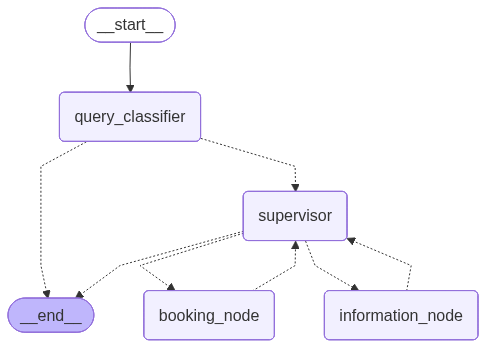

In [32]:
from IPython.display import Image, display
display(
    Image(app.get_graph().draw_mermaid_png())
)

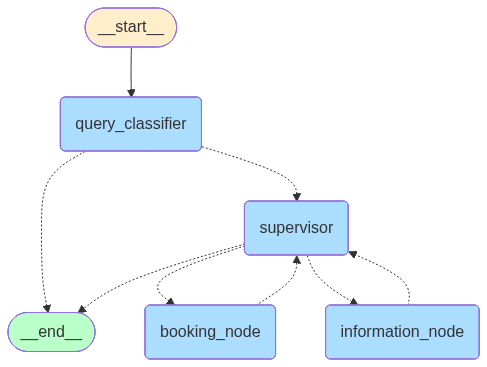

In [53]:
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from IPython.display import display, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
            curve_style= CurveStyle.BASIS,
            node_colors=NodeStyles(
                first="fill:#ffeecc", last="fill:#baffc9", default="fill:#aaddff"
            )
        )
    )
)


In [130]:
print(app.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	query_rewriter(query_rewriter)
	supervisor(supervisor)
	information_node(information_node)
	booking_node(booking_node)
	__end__([<p>__end__</p>]):::last
	__start__ --> query_rewriter;
	query_rewriter -.-> supervisor;
	supervisor -.-> information_node;
	supervisor -.-> booking_node;
	supervisor -.-> __end__;
	information_node -.-> supervisor;
	booking_node -.-> supervisor;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [24]:
state = {
    'query': 'can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?',
    'id_number':10232303
    }

In [25]:
result = app.invoke(state)

**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='Can you check the availability of a general dentist and make a booking for patient 10232303 on August 8, 2024, at 8 PM?', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='9fbae9f1-df4d-459e-8f80-c179606e3d2f')], 'id_number': 10232303, 'query': 'can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?', 'rephrased_query': 'Can you check the availability of a general dentist and make a booking for patient 10232303 on August 8, 2024, at 8 PM?'}
***********************this is my message*****************************************
[{'role': 'system', 'content': "You are a supervisor tasked with managing a conversation between the following workers. ### SPECIALIZED ASSISTANT:\nWORKER: information_node \nDESCRIPTION: Specialized agent to provide information related to doctor availability or FAQs about the hospit

Gemini produced an empty response. Continuing with empty message
Feedback: 


**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='Can you check the availability of a general dentist and make a booking for patient 10232303 on August 8, 2024, at 8 PM?', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='9fbae9f1-df4d-459e-8f80-c179606e3d2f'), AIMessage(content='I can check the availability for a general dentist on August 8, 2024. However, I am not able to make a booking for you. Would you like me to proceed with just checking the availability?', additional_kwargs={}, response_metadata={}, name='information_node', id='d3c29eb3-fb5c-4cbc-acd9-978f25c2397a'), AIMessage(content='', additional_kwargs={}, response_metadata={}, name='information_node', id='324106e0-e3b5-4767-87f8-cac44776b79e')], 'id_number': 10232303, 'query': 'can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?', 'rephrased_query': 'Can you check the availability of 

In [26]:
print(result["messages"][-1].content)

I can check the availability for a general dentist on August 8, 2024. However, I am not able to make a booking for you. Would you like me to proceed with just checking the availability?


In [27]:
state = {
    'query': 'can you check if general dentist available on 8 August 2024? if available show available doctors and time slots',
    'id_number':10232303
    }
result = app.invoke(state)

**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='For patient ID 10232303, are there any general dentists available on August 8, 2024? If so, please list the available doctors and their time slots.', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='1e5b6237-ab7a-4f35-94f7-e9e9c02527e3')], 'id_number': 10232303, 'query': 'can you check if general dentist available on 8 August 2024? if available show available doctors and time slots', 'rephrased_query': 'For patient ID 10232303, are there any general dentists available on August 8, 2024? If so, please list the available doctors and their time slots.'}
***********************this is my message*****************************************
[{'role': 'system', 'content': "You are a supervisor tasked with managing a conversation between the following workers. ### SPECIALIZED ASSISTANT:\nWORKER: information_node \nDESCRIPTION: Specialized agen

In [28]:
print(result["messages"][-1].content)



Please let me know if you would like to book an appointment with a specific doctor or if you have any other questions.


In [29]:
print(result['messages'])

[HumanMessage(content='For patient ID 10232303, are there any general dentists available on August 8, 2024? If so, please list the available doctors and their time slots.', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='1e5b6237-ab7a-4f35-94f7-e9e9c02527e3'), AIMessage(content='Yes, there are general dentists available on August 8, 2024. Here are the available doctors and their time slots:\n\n**Dr. John Doe:**\n* 8:00 AM\n* 9:00 AM\n* 9:30 AM\n* 10:00 AM\n* 12:00 PM\n* 1:30 PM\n* 2:00 PM\n* 3:00 PM\n* 3:30 PM\n* 4:00 PM\n* 4:30 PM\n\n**Dr. Emily Johnson:**\n* 8:00 AM\n* 8:30 AM\n* 10:00 AM\n* 10:30 AM\n* 11:00 AM\n* 11:30 AM\n* 12:00 PM\n* 12:30 PM\n* 1:30 PM\n* 2:30 PM\n* 3:30 PM\n* 4:30 PM', additional_kwargs={}, response_metadata={}, name='information_node', id='e3ca48da-e0a6-4f32-8e77-a3d1c5f7c7f2'), AIMessage(content='\n\nPlease let me know if you would like to book an appointment with a specific doctor or if you have any other questions.', additional_

In [33]:
events = app.stream({
    'query': 'can you check if general dentist available on 8 August 2024? if available show available doctors and time slots',
    'id_number':10232303
    },stream_mode="messages")

for msg_chunk,metadata in events:
    print(msg_chunk.content)

Error in StreamMessagesHandler.on_chain_end callback: TypeError("descriptor '__weakref__' for 'Command' objects doesn't apply to a 'Command' object")


For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.
**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='4c647b83-ea50-4cc0-9d84-deb0602b7947')], 'id_number': 10232303, 'query': 'can you check if general dentist available on 8 August 2024? if available show available doctors and time slots', 'rephrased_query': 'For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.'}
***********************this is my message*****************************************
[{'role': 'system', 'content': "You are a supervisor tasked with managing a conversation between the following workers. ### SPECIALIZED ASSISTANT:\nWORKER: information_node \nDESCRIPTION: 

Error in StreamMessagesHandler.on_chain_end callback: TypeError("descriptor '__weakref__' for 'Command' objects doesn't apply to a 'Command' object")


********************************this is my goto*************************
information_node
********************************
The user is asking for doctor availability, which is handled by the information_node.
**************************below is my state****************************
{'messages': [HumanMessage(content='For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='4c647b83-ea50-4cc0-9d84-deb0602b7947')], 'id_number': 10232303, 'query': 'can you check if general dentist available on 8 August 2024? if available show available doctors and time slots', 'rephrased_query': 'For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.'}

*****************called information node************

The information
_node has two functions: check_availability_by_doctor and check_availability_by
_specialization.
The user is asking 

Error in StreamMessagesHandler.on_chain_end callback: TypeError("descriptor '__weakref__' for 'Command' objects doesn't apply to a 'Command' object")


00 PM, 12:30 PM, 1:30 PM, 2:30 PM, 3:30 PM, 4:30 PM
**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='4c647b83-ea50-4cc0-9d84-deb0602b7947'), AIMessage(content='The user is asking for doctor availability, which is handled by the information_node.', additional_kwargs={}, response_metadata={}, name='supervisor_node', id='46e21e9c-5eb2-4917-be3d-59506d7eb40c'), AIMessage(content='Here are the available general dentists and their time slots on August 8, 2024:\n\nDr. John Doe:\n8:00 AM, 9:00 AM, 9:30 AM, 10:00 AM, 12:00 PM, 1:30 PM, 2:00 PM, 3:00 PM, 3:30 PM, 4:00 PM, 4:30 PM\n\nDr. Emily Johnson:\n8:00 AM, 8:30 AM, 10:00 AM, 10:30 AM, 11:00 AM, 11:30 AM, 12:00 PM, 12:30 PM, 1:30 PM, 2:30 PM, 3:30 PM, 4:30 PM', additional_kwargs={}, r

Error in StreamMessagesHandler.on_chain_end callback: TypeError("descriptor '__weakref__' for 'Command' objects doesn't apply to a 'Command' object")


********************************this is my goto*************************
information_node
********************************
The user is asking for doctor availability, which is handled by the information_node.
**************************below is my state****************************
{'messages': [HumanMessage(content='For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='4c647b83-ea50-4cc0-9d84-deb0602b7947'), AIMessage(content='The user is asking for doctor availability, which is handled by the information_node.', additional_kwargs={}, response_metadata={}, name='supervisor_node', id='46e21e9c-5eb2-4917-be3d-59506d7eb40c'), AIMessage(content='Here are the available general dentists and their time slots on August 8, 2024:\n\nDr. John Doe:\n8:00 AM, 9:00 AM, 9:30 AM, 10:00 AM, 12:00 PM, 1:30 PM, 2:00 PM, 3:00 PM, 3:30 PM, 4:00 PM, 4:30 PM\n\nDr. Emily Johnson:\n8:

Error in StreamMessagesHandler.on_chain_end callback: TypeError("descriptor '__weakref__' for 'Command' objects doesn't apply to a 'Command' object")


, 12:30 PM, 1:30 PM, 2:30 PM, 3:30 PM, 4:30 PMI can help you with that. Could you please confirm the full
 date, including the year, for when you'd like to check the availability of general dentists?
**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='4c647b83-ea50-4cc0-9d84-deb0602b7947'), AIMessage(content='The user is asking for doctor availability, which is handled by the information_node.', additional_kwargs={}, response_metadata={}, name='supervisor_node', id='46e21e9c-5eb2-4917-be3d-59506d7eb40c'), AIMessage(content='Here are the available general dentists and their time slots on August 8, 2024:\n\nDr. John Doe:\n8:00 AM, 9:00 AM, 9:30 AM, 10:00 AM, 12:00 PM, 1:30 PM, 2:00 PM, 3:00 PM, 3:30 PM, 4:00 PM, 4:30 PM\n\nDr. Emily 

Error in StreamMessagesHandler.on_chain_end callback: TypeError("descriptor '__weakref__' for 'Command' objects doesn't apply to a 'Command' object")


********************************this is my goto*************************
information_node
********************************
The user is asking for doctor availability, which is handled by the information_node. The previous response was a placeholder and did not actually call the information_node, so the information_node needs to be called to get the actual availability. The user also needs to confirm the date.
**************************below is my state****************************
{'messages': [HumanMessage(content='For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='4c647b83-ea50-4cc0-9d84-deb0602b7947'), AIMessage(content='The user is asking for doctor availability, which is handled by the information_node.', additional_kwargs={}, response_metadata={}, name='supervisor_node', id='46e21e9c-5eb2-4917-be3d-59506d7eb40c'), AIMessage(content='Here are the availa

Error in StreamMessagesHandler.on_chain_end callback: TypeError("descriptor '__weakref__' for 'Command' objects doesn't apply to a 'Command' object")


, 4:30 PM
**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='4c647b83-ea50-4cc0-9d84-deb0602b7947'), AIMessage(content='The user is asking for doctor availability, which is handled by the information_node.', additional_kwargs={}, response_metadata={}, name='supervisor_node', id='46e21e9c-5eb2-4917-be3d-59506d7eb40c'), AIMessage(content='Here are the available general dentists and their time slots on August 8, 2024:\n\nDr. John Doe:\n8:00 AM, 9:00 AM, 9:30 AM, 10:00 AM, 12:00 PM, 1:30 PM, 2:00 PM, 3:00 PM, 3:30 PM, 4:00 PM, 4:30 PM\n\nDr. Emily Johnson:\n8:00 AM, 8:30 AM, 10:00 AM, 10:30 AM, 11:00 AM, 11:30 AM, 12:00 PM, 12:30 PM, 1:30 PM, 2:30 PM, 3:30 PM, 4:30 PM', additional_kwargs={}, response_metadata={}, name='information_nod

Error in StreamMessagesHandler.on_chain_end callback: TypeError("descriptor '__weakref__' for 'Command' objects doesn't apply to a 'Command' object")


********************************this is my goto*************************

information_node
********************************
The user is asking for doctor availability for a specific date and type of doctor. The information_node is responsible for providing this information. The previous turn did not fully resolve the request by providing the actual availability from the information_node.
**************************below is my state****************************
{'messages': [HumanMessage(content='For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='4c647b83-ea50-4cc0-9d84-deb0602b7947'), AIMessage(content='The user is asking for doctor availability, which is handled by the information_node.', additional_kwargs={}, response_metadata={}, name='supervisor_node', id='46e21e9c-5eb2-4917-be3d-59506d7eb40c'), AIMessage(content='Here are the available general dentists a

Error in StreamMessagesHandler.on_chain_end callback: TypeError("descriptor '__weakref__' for 'Command' objects doesn't apply to a 'Command' object")


 dentists and their time slots. I also need to confirm the year with the user, as the current date format is ambiguous.I can help you with that. Could you please confirm the full date, including the year, for when you'd like
 to check the availability of general dentists?
**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='4c647b83-ea50-4cc0-9d84-deb0602b7947'), AIMessage(content='The user is asking for doctor availability, which is handled by the information_node.', additional_kwargs={}, response_metadata={}, name='supervisor_node', id='46e21e9c-5eb2-4917-be3d-59506d7eb40c'), AIMessage(content='Here are the available general dentists and their time slots on August 8, 2024:\n\nDr. John Doe:\n8:00 AM, 9:00 AM, 9:30 AM, 10:00 AM, 12:

Error in StreamMessagesHandler.on_chain_end callback: TypeError("descriptor '__weakref__' for 'Command' objects doesn't apply to a 'Command' object")


********************************this is my goto*************************
information_node
********************************
The user is asking for doctor availability for a specific date and specialization. The `information_node` is responsible for providing this information. I will call the `check_availability_by_specialization` tool within the `information_node` to get the available general dentists and their time slots for August 8, 2024.
**************************below is my state****************************
{'messages': [HumanMessage(content='For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='4c647b83-ea50-4cc0-9d84-deb0602b7947'), AIMessage(content='The user is asking for doctor availability, which is handled by the information_node.', additional_kwargs={}, response_metadata={}, name='supervisor_node', id='46e21e9c-5eb2-4917-be3d-59506d7eb40c'), AIMess

Error in StreamMessagesHandler.on_chain_end callback: TypeError("descriptor '__weakref__' for 'Command' objects doesn't apply to a 'Command' object")


 that. Could you please confirm the full date, including the year, for when you'd like to check the availability of general dentists?
**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='For patient 10232303, please list the available general dentists and their time slots on 8 August 2024.', additional_kwargs={}, response_metadata={}, name='query_rewriter_node', id='4c647b83-ea50-4cc0-9d84-deb0602b7947'), AIMessage(content='The user is asking for doctor availability, which is handled by the information_node.', additional_kwargs={}, response_metadata={}, name='supervisor_node', id='46e21e9c-5eb2-4917-be3d-59506d7eb40c'), AIMessage(content='Here are the available general dentists and their time slots on August 8, 2024:\n\nDr. John Doe:\n8:00 AM, 9:00 AM, 9:30 AM, 10:00 AM, 12:00 PM, 1:30 PM, 2:00 PM, 3:00 PM, 3:30 PM, 4:00 PM, 4:30 PM\n\nDr. Emily Johnson:\n8:00 AM, 8:30 AM, 10:00 AM, 10:30 AM, 11:00 AM, 11:30 AM

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 42
}
].


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 39
}
]

In [1]:
from langchain.prompts import ChatPromptTemplate

chat_template=ChatPromptTemplate([
    ('system', 'You are a helpful {domain} expert'),
    ('user', 'Explain in simple terms, what is {topic}')
])

prompt=chat_template.invoke({
    'domain':'cricket','topic':'dusra'
})

print(prompt)

messages=[SystemMessage(content='You are a helpful cricket expert', additional_kwargs={}, response_metadata={}), HumanMessage(content='Explain in simple terms, what is dusra', additional_kwargs={}, response_metadata={})]
